# Identifikasi Masalah
## Latar Belakang
Dalam dunia akademik, artikel ilmiah diterbitkan setiap hari. Volume informasi ini menyulitkan akademisi baik itu mahasiswa, dosen, dan peneliti untuk mengikuti perkembangan terbaru secara menyeluruh. Disinilah penting nya topic modeling, dengan teknik ini, kita dapat secara otomatis mengelompokkan kumpulan abstrak artikel ilmiah ke dalam topik-topik utama seperti Artificial Intelligence, Cybersecurity, atau Computer Vision.

Topic modeling memungkinkan kita untuk:

- Mengidentifikasi tren penelitian yang sedang berkembang.
- Menemukan artikel relevan tanpa membaca satu per satu.
- Menyederhanakan eksplorasi literatur dalam jumlah besar.

Dalam tugas ini, kita akan membandingkan dua metode topic modeling:

- Latent Dirichlet Allocation (LDA).
- BERTopic.

Fokus tugas ini yaitu menilai model mana yang memberikan hasil pengelompokan topik yang lebih relevan, dapat dimengerti, dan sesuai dengan kategori asli artikel.

## Pertanyaan Penelitian
1. Topik apa saja yang berhasil ditemukan oleh masing-masing metode?

2. Berapa jumlah topik optimal, dan model mana yang memberikan skor kualitas topik terbaik?

3. Seberapa sesuai hasil topik dari masing-masing metode dengan label kategori asli dari artikel?



# Pengumpulan Dataset
## Sumber Data
Untuk tugas topic modeling ini, dataset yang digunakan adalah dataset publik "ArXiv Dataset" yang tersedia di platform Kaggle. Dataset ini berisi metadata dari jutaan publikasi ilmiah dari penerbit arXiv.org.

Setiap entri mencakup informasi seperti:
- id: ID unik artikel
- title: Judul artikel
- abstract: Ringkasan isi artikel (digunakan sebagai teks utama analisis)
- categories: Label bidang ilmu (misal: cs.AI, cs.CV, math.CO) yang akan digunakan untuk evaluasi model
- update_date: Tanggal terakhir artikel diperbarui

Dataset ini cocok dengan implementasi topic modeling karena berisi abstrak berkualitas tinggi, terstruktur, dan kaya informasi—ideal untuk pemrosesan bahasa alami (NLP).

Link Kaggle : https://www.kaggle.com/datasets/Cornell-University/arxiv

## Pengumpulan Data
Dataset asli berukuran besar (lebih dari 2 juta entri) dan disimpan dalam format JSON Lines (.jsonl), di mana setiap baris adalah satu objek JSON.

Supaya lebih relevan, dataset yang artikel yang digunakan hanya tahun 2021 keatas. Dari tahap ini, diperoleh DataFrame akhir (df_recent) dengan 1.082.975 baris. Karena keterbatasan komputasi, maka diambil sample sebanyak 10.000 saja.

In [1]:
# Ini merupakan kode dari kaggle sendiri untuk mendownload dataset nya
import kagglehub

# Download latest version
path = kagglehub.dataset_download("Cornell-University/arxiv")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/arxiv


In [2]:
"""Kode ini digunakan untuk memindahkan file dataset yang telah ter download
kedalam direktori '/content/dataset' google colab"""
import shutil
# Source folder dari kagglehub
src_path = "/kaggle/input/arxiv"

# Target folder (direktori kerja biasa)
dst_path = "/content/dataset"

# Salin semua isi folder
shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

print("Dataset telah dipindahkan ke:", dst_path)

Dataset telah dipindahkan ke: /content/dataset


In [3]:
"""Kode dibawah digunakan untuk mengkonversi file dataset yang berformat json
ke dalam pandas dataframe, dan saat proses nya difilter hanya artikel atau paper
dengan tahun >= 2021"""

import pandas as pd
import json

data = []
file_path = '/content/dataset/arxiv-metadata-oai-snapshot.json'
start_year = 2021

with open(file_path, 'r') as f:
    for line in f:
        # Megubah setiap baris menjadi dictionary
        parsed_line = json.loads(line)

        # Membaca tahun dari kolom 'update_date'
        # try-except digunakan untuk antisipasi mana tau ada data yang aneh
        try:
            # Mendapatkan tahun dari kolom 'update date'
            year = int(parsed_line['update_date'][:4])

            # Simpan data >= 2021
            if year >= start_year:
                data.append(parsed_line)
        except (ValueError, TypeError):
            # Jika ada error maka dilanjutkan proses nya
            continue

# Membuat dataframe dari data-data yang sudah difilter
df = pd.DataFrame(data)

# Cek hasil dataframe
if not df.empty:
    print(f"Berhasil membaca {len(df)} baris data dari tahun {start_year} ke atas.")
    print("\nInformasi DataFrame:")
    df.info()

    print("\n5 baris pertama data terbaru:")
    print(df.head())
else:
    print(f"Tidak ada data yang ditemukan dari tahun {start_year} ke atas.")

Berhasil membaca 1082975 baris data dari tahun 2021 ke atas.

Informasi DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1082975 entries, 0 to 1082974
Data columns (total 14 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   id              1082975 non-null  object
 1   submitter       1082943 non-null  object
 2   authors         1082975 non-null  object
 3   title           1082975 non-null  object
 4   comments        690061 non-null   object
 5   journal-ref     213164 non-null   object
 6   doi             324122 non-null   object
 7   report-no       25892 non-null    object
 8   categories      1082975 non-null  object
 9   license         1081657 non-null  object
 10  abstract        1082975 non-null  object
 11  versions        1082975 non-null  object
 12  update_date     1082975 non-null  object
 13  authors_parsed  1082975 non-null  object
dtypes: object(14)
memory usage: 115.7+ MB

5 baris pertama data ter

In [4]:
"""Kode pada cell ini berfungsi untuk mengambil 10.000 data dari dataset
Hal ini dilakukan karena dataset terlalu besar dan tidak cukup komputasi."""

sample_size = 10000

print(f"\nUkuran DataFrame asli: {len(df)} baris.")

# Menyimpan 10.000 data ke df_sampled
df_sampled = df.sample(n=sample_size, random_state=42)

print(f"Ukuran DataFrame setelah di-sample: {len(df_sampled)} baris.")

# Timpa df asli dengan df_sampled (tidak digunakan lagi)
df = df_sampled.copy()

# Reset index DataFrame yang sudah dilakukan proses sample
df.reset_index(drop=True, inplace=True)

# Cek jumlah baris
df.shape


Ukuran DataFrame asli: 1082975 baris.
Ukuran DataFrame setelah di-sample: 10000 baris.


(10000, 14)

# Pra-pemrosesan Teks (pre-processing)
Proses ini dilakukan sesuai dengan intruksi soal.

In [5]:
# Kode dibawah adalah mendownload beberapa modul dari NLTK untu pre-processing teks
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [7]:
"""Kode ini digunakan untuk menggabungkan judul artikel dan abstrak menjadi
kolom teks untuk memperkaya informasi supaya LDA dan BertTopic lebih bisa
menangkap pola dan topik lebih baik"""

df['text'] = df['title'].fillna('') + ' ' + df['abstract'].fillna('')

In [8]:
"""Kode dibawah didunakan untuk mendefinisikan fungsi pre-processing
yang akan diaplikasikan pada dataset"""

import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Inisialisasi lemmatizer dan stopwords
lemmatizer = WordNetLemmatizer()
# Menggunakan stopwords berbahasa inggris karena dataset artikel berhasasa inggris
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Case Folding: Mengubah semua teks menjadi huruf kecil
    text = text.lower()

    # Filtering
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'[^a-z\s]', '', text)

    # Tokenisasi: Memecah teks menjadi token
    tokens = word_tokenize(text)

    # Stopword Removal & Lemmatization & Filtering kata pendek
    cleaned_tokens = []
    for word in tokens:
        # Cek apakah kata bukan stopword dan panjangnya lebih dari 2 huruf
        if word not in stop_words and len(word) > 2:
            # Lemmatization: Mengubah kata ke bentuk dasarnya
            cleaned_tokens.append(lemmatizer.lemmatize(word))

    return cleaned_tokens

In [9]:
# Test hasil fungsi pre-processing yang telah dibuat
print("Hasil uji coba pra-pemrosesan pada 5 baris pertama:")
contoh_hasil = df['text'].head(5).apply(preprocess_text)
print(contoh_hasil)

Hasil uji coba pra-pemrosesan pada 5 baris pertama:
0    [supervised, anomaly, detection, method, combi...
1    [balanced, excited, random, walk, two, dimensi...
2    [inference, multiple, highdimensional, network...
3    [summarize, generate, backtranslate, unsupervi...
4    [entity, alignment, knowledge, graph, progress...
Name: text, dtype: object


In [10]:
# Mengaplikasikan fungsi pada seluruh data di dataset dan disimpan pada kolom baru
df['processed_text'] = df['text'].apply(preprocess_text)

In [11]:
# Menampilkan dataset sebelum dan sesudah pre-processing
print(df[['text', 'processed_text']].sample(5))

                                                   text  \
9528  The generalized roof F(1,2,n): Hodge structure...   
1933  Data-integration with pseudoweights and survey...   
6895  Fig Tree-Wasp Symbiotic Coevolutionary Optimiz...   
9599  Deep reinforcement learning for irrigation sch...   
2009  Analysis of the hidden-charm tetraquark molecu...   

                                         processed_text  
9528  [generalized, roof, hodge, structure, derived,...  
1933  [dataintegration, pseudoweights, surveycalibra...  
6895  [fig, treewasp, symbiotic, coevolutionary, opt...  
9599  [deep, reinforcement, learning, irrigation, sc...  
2009  [analysis, hiddencharm, tetraquark, molecule, ...  


# Penerapan Algoritma Topic Modeling

## LDA
Penerapan algorima LDA pada tugas ini mengunakan library gensim, untuk dapat diaplikasikan pada LDA, kolom processed_text wajib diubah dalam bentuk dictionary lalu corpus. Saat mengkonversi kedalam dictionary, kata-kata dengan kemunculan kurang dari 15 dihapus dan jika muncul diatas 50% dari dokumen juga dihapus (dianggap umum), lalu setelah itu dijadikan corpus dengan metode BoW.

In [1]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 69.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 96.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.16.0
    Uninstalling scipy-1.16.0:
      Successfully uninstalled scipy-1.16.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.0 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
opencv-contrib-

In [12]:
"""Kode cell ini berfungsi untuk membuat corpus dan dictionary, karena LDA
akan dijalankan dengan gensim yang membutuhkan corpus dan dictionary."""
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import pandas as pd

documents = [doc for doc in df['processed_text'] if doc]

# Membuat Dictionary (memetakan setiap kata unik menjadi sebuah ID)
dictionary = Dictionary(documents)

# Memfilter kata eksrim, kata kuran dari 15 dan lebih dari 50% isi dokumen dihapus
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

# Membuat Corpus dengan Bag-of-Words
# BoW mengubah setiap dokumen menjadi representasi (ID kata, frekuensi)
corpus = [dictionary.doc2bow(doc) for doc in documents]

print(f"Jumlah kata unik dalam kamus setelah filtering: {len(dictionary)}")
print(f"Jumlah dokumen dalam corpus: {len(corpus)}")

Jumlah kata unik dalam kamus setelah filtering: 5276
Jumlah dokumen dalam corpus: 10000


In [13]:
# Latih model LDA
# Jumah topik awal adalah 10
NUM_TOPICS = 10

lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=NUM_TOPICS,
    random_state=42,
    passes=10,
    alpha='auto',
    eta='auto'
)

In [14]:
# Menampilkan 10 kata kunci teratas untuk setiap topik
print("\nTopik yang ditemukan oleh LDA:")
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)


Topik yang ditemukan oleh LDA:
(0, '0.031*"model" + 0.014*"learning" + 0.013*"method" + 0.011*"data" + 0.010*"image" + 0.010*"task" + 0.009*"network" + 0.009*"performance" + 0.009*"training" + 0.007*"neural"')
(1, '0.014*"data" + 0.009*"using" + 0.009*"observation" + 0.009*"source" + 0.007*"model" + 0.007*"spectrum" + 0.007*"analysis" + 0.006*"emission" + 0.006*"measurement" + 0.006*"result"')
(2, '0.011*"material" + 0.009*"energy" + 0.007*"optical" + 0.007*"property" + 0.007*"using" + 0.006*"high" + 0.006*"molecular" + 0.006*"surface" + 0.006*"structure" + 0.006*"mode"')
(3, '0.013*"algorithm" + 0.011*"network" + 0.010*"system" + 0.009*"control" + 0.007*"learning" + 0.007*"proposed" + 0.007*"video" + 0.007*"environment" + 0.007*"performance" + 0.007*"method"')
(4, '0.024*"method" + 0.019*"problem" + 0.014*"algorithm" + 0.013*"equation" + 0.012*"solution" + 0.011*"model" + 0.010*"time" + 0.009*"function" + 0.009*"system" + 0.009*"approach"')
(5, '0.061*"graph" + 0.021*"star" + 0.017*"

## BERTopic
Pada pemodelan BERTopic sedikit berbeda, BERTopic lebih cangih dalam menangkap semantik pada kata sehingga teks utuk lah yang akan diaplikasikan pada model ini. Model embedding yang digunakan adalah "all-MiniLM-L6-v2".

In [15]:
!pip install bertopic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 53.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 32.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 983.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 29.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [16]:
import torch

# Menggunakan GPU T4 dari google colab
if torch.cuda.is_available():
    print("GPU terdeteksi!")
    print(f"Nama GPU: {torch.cuda.get_device_name(0)}")
    device = "cuda"
else:
    # Jika tidak, beri peringatan
    print("GPU tidak ditemukan.")
    device = "cpu"

GPU terdeteksi!
Nama GPU: Tesla T4


### Klarifikasi
Progress Bar (output cell) saat training model BERTOpic dihapus, dikarenakan tidak dapat ditampilkan (preview) oleh GitHub.

In [ ]:
"""Kode dibawah adalah kode untuk melakukan pemodelan dengan BERTopic."""

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
import pandas as pd

# Pada tugas ini, model embedding yang digunakan adlaah "all-MiniLM-L6-v2"
embedding_model_name = "all-MiniLM-L6-v2"

# Memuat model ke GPU dengan SentenceTransformer
embedding_model = SentenceTransformer(embedding_model_name, device=device)

print(f"Embedding model '{embedding_model_name}' siap digunakan di {device}.")

# Inisiasi BERTopic
topic_model = BERTopic(
    embedding_model=embedding_model,
    language="english",
    calculate_probabilities=True,
    verbose=True, #
    min_topic_size=50
)

# Mempersiapkan dokumen dari kolom 'text'
docs_for_bertopic = df['text'].tolist()

# Training model BERTopic
topics, probs = topic_model.fit_transform(docs_for_bertopic)

In [18]:
# Menampilkan hasil BERTopic
print("\nRingkasan topik yang ditemukan oleh BERTopic:")
print(topic_model.get_topic_info())


Ringkasan topik yang ditemukan oleh BERTopic:
    Topic  Count                         Name  \
0      -1    833              -1_the_of_in_we   
1       0   4948              0_the_and_to_of   
2       1   1188              1_the_of_and_in   
3       2    858              2_the_of_in_and   
4       3    551              3_of_the_we_and   
5       4    380          4_quantum_the_of_to   
6       5    324              5_the_of_and_in   
7       6    223            6_the_of_black_in   
8       7    173               7_of_the_we_in   
9       8    170        8_graphs_graph_of_the   
10      9    166  9_the_of_solutions_equation   
11     10    129             10_of_the_in_and   
12     11     57         11_codes_the_of_code   

                                       Representation  \
0       [the, of, in, we, and, for, is, to, that, on]   
1       [the, and, to, of, in, for, we, on, that, is]   
2     [the, of, and, in, to, with, we, for, is, that]   
3      [the, of, in, and, to, spin, we

# Evaluasi

Memulai perhitungan Coherence Score
Selesai menghitung untuk 5 topik.
Selesai menghitung untuk 10 topik.
Selesai menghitung untuk 15 topik.
Selesai menghitung untuk 20 topik.
Selesai menghitung untuk 25 topik.
Selesai menghitung untuk 30 topik.
Selesai menghitung untuk 35 topik.
Selesai menghitung untuk 40 topik.


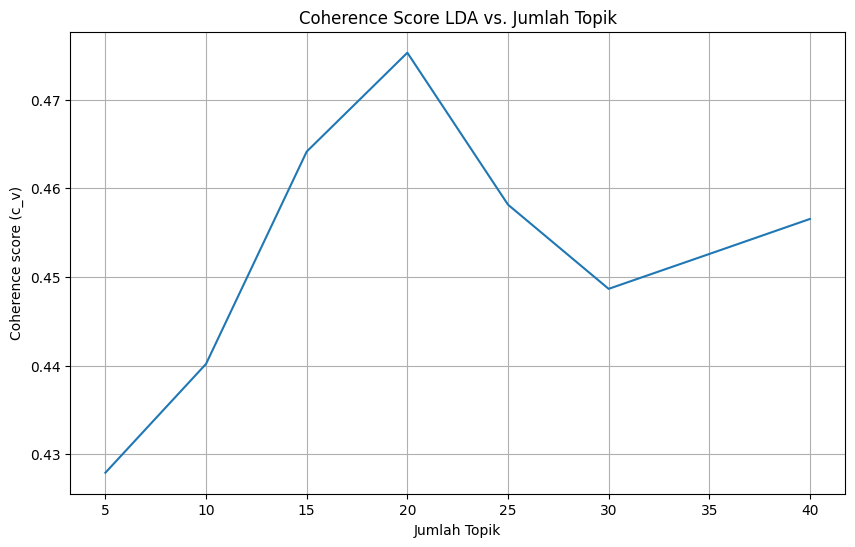


Jumlah topik optimal untuk LDA adalah: 20 dengan Coherence Score 0.4753


In [19]:
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    #Menghitung skor koherensi untuk berbagai jumlah topik.
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, random_state=42, passes=5)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        print(f"Selesai menghitung untuk {num_topics} topik.")
    return model_list, coherence_values

# Menentukan rentang jumlah topik yang ingin diuji
# Uji dari 5 sampai 40 topik, dengan loncatan 5
start=5; limit=41; step=5;

print("Memulai perhitungan Coherence Score")
model_list_lda, coherence_values_lda = compute_coherence_values(
    dictionary=dictionary,
    corpus=corpus,
    texts=documents,
    start=start,
    limit=limit,
    step=step
)

# Visualisasi hasil
x = range(start, limit, step)
plt.figure(figsize=(10, 6))
plt.plot(x, coherence_values_lda)
plt.xlabel("Jumlah Topik")
plt.ylabel("Coherence score (c_v)")
plt.title("Coherence Score LDA vs. Jumlah Topik")
plt.xticks(x)
plt.grid(True)
plt.show()

# Mencari skor teritnggi
optimal_idx = coherence_values_lda.index(max(coherence_values_lda))
optimal_num_topics_lda = x[optimal_idx]
print(f"\nJumlah topik optimal untuk LDA adalah: {optimal_num_topics_lda} dengan Coherence Score {max(coherence_values_lda):.4f}")

In [20]:
# Kita gunakan jumlah topik optimal yang kita temukan dari grafik
OPTIMAL_NUM_TOPICS = 20

print(f"Melatih satu model LDA final dengan {OPTIMAL_NUM_TOPICS} topik...")

# Latih model LDA terbaik kita dengan parameter yang sama
best_lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=OPTIMAL_NUM_TOPICS,
    random_state=42,       # Pastikan random_state sama untuk konsistensi
    passes=10,             # Jumlah iterasi training
    alpha='auto',
    eta='auto'
)

# Tampilkan 10 kata kunci teratas untuk setiap topik dari model terbaik
print("\nTopik yang ditemukan oleh model LDA terbaik (K=20):")
topics = best_lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

Melatih satu model LDA final dengan 20 topik...

Topik yang ditemukan oleh model LDA terbaik (K=20):
(0, '0.051*"network" + 0.023*"neural" + 0.022*"model" + 0.012*"training" + 0.012*"learning" + 0.011*"performance" + 0.010*"architecture" + 0.009*"deep" + 0.008*"accuracy" + 0.007*"data"')
(1, '0.019*"star" + 0.012*"observation" + 0.010*"emission" + 0.010*"source" + 0.009*"spectrum" + 0.007*"line" + 0.007*"data" + 0.006*"binary" + 0.006*"stellar" + 0.006*"mass"')
(2, '0.012*"optical" + 0.011*"frequency" + 0.011*"mode" + 0.011*"material" + 0.009*"electron" + 0.008*"using" + 0.008*"device" + 0.008*"beam" + 0.008*"high" + 0.008*"signal"')
(3, '0.041*"control" + 0.033*"agent" + 0.025*"policy" + 0.022*"environment" + 0.020*"robot" + 0.019*"system" + 0.018*"trajectory" + 0.017*"vehicle" + 0.017*"motion" + 0.016*"reinforcement"')
(4, '0.048*"equation" + 0.032*"solution" + 0.023*"system" + 0.018*"condition" + 0.016*"nonlinear" + 0.013*"dynamic" + 0.013*"numerical" + 0.013*"boundary" + 0.012*"met

In [21]:
print("Ringkasan topik dari BERTopic:")
topic_info = topic_model.get_topic_info()
print(topic_info)

print(f"\nBERTopic secara otomatis menemukan {len(topic_info) - 1} topik (tidak termasuk topik -1/outliers).")

Ringkasan topik dari BERTopic:
    Topic  Count                         Name  \
0      -1    833              -1_the_of_in_we   
1       0   4948              0_the_and_to_of   
2       1   1188              1_the_of_and_in   
3       2    858              2_the_of_in_and   
4       3    551              3_of_the_we_and   
5       4    380          4_quantum_the_of_to   
6       5    324              5_the_of_and_in   
7       6    223            6_the_of_black_in   
8       7    173               7_of_the_we_in   
9       8    170        8_graphs_graph_of_the   
10      9    166  9_the_of_solutions_equation   
11     10    129             10_of_the_in_and   
12     11     57         11_codes_the_of_code   

                                       Representation  \
0       [the, of, in, we, and, for, is, to, that, on]   
1       [the, and, to, of, in, for, we, on, that, is]   
2     [the, of, and, in, to, with, we, for, is, that]   
3      [the, of, in, and, to, spin, we, with, by, is] 

In [22]:
# Lihat 15 topik teratas dari BERTopic (berdasarkan jumlah dokumen)
topic_info = topic_model.get_topic_info()
print(topic_info.head(15))

# Mari kita lihat isi dari beberapa topik teratas yang menarik
print("\nDetail untuk Topik 0:")
print(topic_model.get_topic(0))

print("\nDetail untuk Topik 2:")
print(topic_model.get_topic(2))

    Topic  Count                         Name  \
0      -1    833              -1_the_of_in_we   
1       0   4948              0_the_and_to_of   
2       1   1188              1_the_of_and_in   
3       2    858              2_the_of_in_and   
4       3    551              3_of_the_we_and   
5       4    380          4_quantum_the_of_to   
6       5    324              5_the_of_and_in   
7       6    223            6_the_of_black_in   
8       7    173               7_of_the_we_in   
9       8    170        8_graphs_graph_of_the   
10      9    166  9_the_of_solutions_equation   
11     10    129             10_of_the_in_and   
12     11     57         11_codes_the_of_code   

                                       Representation  \
0       [the, of, in, we, and, for, is, to, that, on]   
1       [the, and, to, of, in, for, we, on, that, is]   
2     [the, of, and, in, to, with, we, for, is, that]   
3      [the, of, in, and, to, spin, we, with, by, is]   
4   [of, the, we, and, in, i

In [23]:
def get_dominant_topic(doc_bow):
    """
    Mendapatkan ID topik dengan probabilitas tertinggi untuk satu dokumen.
    """
    try:
        topic_dist = best_lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
        dominant_topic = max(topic_dist, key=lambda x: x[1])
        return dominant_topic[0]
    except:
        # Jika dokumen kosong setelah preprocessing, kembalikan nilai null
        return None

# Pastikan panjang corpus dan df sesuai
if len(corpus) == len(df):
    print("Memproses setiap dokumen untuk menemukan topik dominannya dari LDA...")

    # Buat list berisi topik dominan untuk setiap dokumen
    lda_topics = [get_dominant_topic(doc) for doc in corpus]

    # Buat kolom baru di DataFrame
    df['lda_topic'] = lda_topics

    print("Selesai. Kolom 'lda_topic' berhasil ditambahkan.")

    # Verifikasi hasilnya:
    print("\nContoh hasil pelabelan topik LDA:")
    print(df[['text', 'lda_topic']].head())

    print("\nDistribusi dokumen per topik LDA:")
    print(df['lda_topic'].value_counts().sort_index())
else:
    print("Error: Panjang corpus LDA tidak sama dengan panjang DataFrame.")

Memproses setiap dokumen untuk menemukan topik dominannya dari LDA...
Selesai. Kolom 'lda_topic' berhasil ditambahkan.

Contoh hasil pelabelan topik LDA:
                                                text  lda_topic
0  Supervised Anomaly Detection Method Combining ...         14
1  Balanced Excited Random Walk in Two Dimensions...          8
2  Inference of multiple high-dimensional network...         17
3  Summarize and Generate to Back-translate: Unsu...         18
4  Entity Alignment For Knowledge Graphs: Progres...         18

Distribusi dokumen per topik LDA:
lda_topic
0      557
1      491
2      479
3      150
4      427
5      107
6     1063
7      473
8      152
9      906
10     251
11     475
12     654
13      69
14    1174
15     604
16     246
17     525
18     838
19     359
Name: count, dtype: int64


In [25]:
def analyze_lda_topic(topic_id):
    """
    Menganalisis dan menampilkan komposisi kategori asli
    untuk sebuah topik dari LDA.
    """
    print(f"\n--- Menganalisis Topik LDA #{topic_id} ---")

    # Ambil kata kunci utama dari topik ini
    keywords = [word for word, _ in best_lda_model.show_topic(topic_id, topn=10)]
    print(f"Kata Kunci Topik: {keywords}")

    # Filter paper yang termasuk dalam topik ini
    papers_in_topic = df[df['lda_topic'] == topic_id]

    if papers_in_topic.empty:
        print("Tidak ada dokumen yang termasuk dalam topik ini.")
        return

    # Hitung frekuensi setiap kategori asli
    kategori_counts = papers_in_topic['categories'].str.split(' ').explode().value_counts()

    print("\n5 Kategori Asli Teratas dalam Topik ini:")
    print(kategori_counts.head(5))
    print("-"*(len(f"Menganalisis Topik LDA #{topic_id}") + 4))

# Analisis semua 20 topik dari LDA
print("\n" + "="*50)
print("ANALISIS VALIDASI EKSTERNAL UNTUK SETIAP TOPIK LDA")
print("="*50)

if 'lda_topic' in df.columns:
    for i in range(best_lda_model.num_topics):
        analyze_lda_topic(i)
else:
    print("Kolom 'lda_topic' belum ada.")


ANALISIS VALIDASI EKSTERNAL UNTUK SETIAP TOPIK LDA

--- Menganalisis Topik LDA #0 ---
Kata Kunci Topik: ['network', 'neural', 'model', 'training', 'learning', 'performance', 'architecture', 'deep', 'accuracy', 'data']

5 Kategori Asli Teratas dalam Topik ini:
categories
cs.LG      308
cs.AI      122
cs.CV       78
cs.DC       51
stat.ML     40
Name: count, dtype: int64
-----------------------------

--- Menganalisis Topik LDA #1 ---
Kata Kunci Topik: ['star', 'observation', 'emission', 'source', 'spectrum', 'line', 'data', 'binary', 'stellar', 'mass']

5 Kategori Asli Teratas dalam Topik ini:
categories
astro-ph.GA    176
astro-ph.HE    148
astro-ph.SR    129
astro-ph.EP     94
astro-ph.CO     59
Name: count, dtype: int64
-----------------------------

--- Menganalisis Topik LDA #2 ---
Kata Kunci Topik: ['optical', 'frequency', 'mode', 'material', 'electron', 'using', 'device', 'beam', 'high', 'signal']

5 Kategori Asli Teratas dalam Topik ini:
categories
physics.optics       136
cond

## Perbandingan Kualitas Topik

Bagian ini akan membandingkan kualitas hasil topik yang dihasilkan kedua model secara kualitatif. Fokus utama yaitu seberapa mudah topik-topik dari kedua model dapat dipahami, seberapa koheren istilah-istilah yang muncul, dan sejauh mana relevansinya dengan konteks artikel ilmiah.

Perbandingan dilakukan dengan melihat sejumlah tema yang berhasil ditangkap oleh LDA—karena hasilnya lebih jelas, kemudian mencocokkannya dengan topik yang kira-kira serupa pada BERTopic.

---

## Machine Learning & Computer Vision

**LDA (Topik 14)**  
`['learning', 'method', 'image', 'data', 'model', 'feature', 'detection', 'object', 'approach', 'training']`

**Interpretasi**  
Topik ini muncul sangat koheren dan fokus. Kumpulan kata kunci yang muncul jelas mengarah ke ranah Computer Vision dan Machine Learning. Istilah seperti *image*, *detection*, dan *object* memperkuat dugaan ini. Validasi lebih lanjut juga menunjukkan bahwa topik ini memang berasal dari kategori cs.CV dan cs.LG, yang mempertegas relevansinya secara eksternal.

**BERTopic (Topik 0)**  
`['the', 'and', 'to', 'of', 'in', 'for', 'we', 'on', 'that', 'is']`

**Interpretasi**  
topik utama yang dihasilkan BERTopic justru dipenuhi kata-kata umum yang seharusnya sudah disaring (stopwords). Hasil ini sulit dimengerti karena tidak menyampaikan tema atau konteks apa pun secara jelas.

**Kesimpulan Sementara**  
Di tema ini, LDA memiliki performa jauh lebih baik. LDA mampu merangkum esensi ribuan abstrak dari domain Computer Vision ke dalam satu topik yang ringkas dan padat makna. Sebaliknya, BERTopic gagal memberikan representasi tematik yang berarti dengan konfigurasi standar yang digunakan.

---

## Fisika Kuantum

**LDA (Topik 16)**  
`['quantum', 'state', 'theory', 'classical', 'circuit', 'model', 'approach', 'information', 'using', 'work']`

**Interpretasi**  
Topik ini muncul dengan fokus yang kuat dan mudah diidentifikasi. Kata *quantum* menjadi pusatnya, disusul oleh istilah khas seperti *state*, *theory*, dan *circuit*. Secara keseluruhan, ini sangat menggambarkan ranah teori dan komputasi kuantum.

**BERTopic (Topik 4)**  
`['quantum', 'the', 'of', 'to', 'and', 'in', 'we', 'for', 'that', 'is']`

**Interpretasi**  
BERTopic sebenarnya cukup berhasil menangkap kata utama dengan menempatkan *quantum* di urutan pertama. Namun, representasi topiknya masih tercemar oleh kata-kata umum, membuatnya terasa kurang tajam dan sulit ditelaah secara tematik.

**Kesimpulan Sementara**  
Meskipun BERTopic bisa mendeteksi tema besarnya, LDA masih menghasilkan keluaran yang lebih bersih dan informatif. LDA tidak hanya menunjukkan kata utama, tetapi juga konteks dan struktur tematik yang lebih kuat.

---

## Matematika & Teori Graf

**LDA (Topik 10)**  
`['graph', 'bound', 'number', 'set', 'show', 'vertex', 'tree', 'upper', 'result', 'lower']`

**Interpretasi**  
Topik ini sangat relevan untuk matematika, terutama teori graf. Kata-kata seperti *graph*, *vertex*, *tree*, dan *bound* merupakan istilah khas yang biasa digunakan dalam bidang itu, sehingga topik ini sangat mudah dikenali oleh siapa pun yang familiar dengan area ini.

**BERTopic (Topik 8)**  
`['graphs', 'graph', 'of', 'the', 'is', 'for', 'and', 'we', 'in', 'this']`

**Interpretasi**  
Sama seperti pada tema kuantum, BERTopic berhasil menangkap kata utama seperti *graph* dan *graphs*. Tapi karena kata-kata pendukung lainnya terlalu umum, gambaran utuh topik ini jadi terasa dangkal.

**Kesimpulan Sementara**  
Masih seperti kondisi evaluasi topik sebelumnya, LDA menghasilkan topik yang lebih solid secara konten dan lebih mudah diinterpretasikan oleh peneliti di bidang terkait. Sementara BERTopic, meskipun menangkap kata inti, tidak menyajikan konteks yang cukup kaya.

---

## Kesimpulan Umum

Dari ketiga tema yang dievaluasi, terlihat konsistensi yang cukup jelas: LDA secara konsisten menghasilkan topik-topik yang lebih jernih, spesifik, dan bermakna. Dengan dukungan *pre-processing* yang tepat dan pemilihan jumlah topik yang sesuai, LDA terbukti efektif dalam mengurai ribuan artikel ilmiah menjadi kumpulan tema yang informatif dan mudah dipahami. Sebaliknya, BERTopic dalam konfigurasi *default* masih tertinggal dalam menyaring kata-kata yang benar-benar relevan secara tematik.


## Kesimpulan

Berdasarkan analisis dan evaluasi yang telah dilakukan pada 10.000 abstrak artikel dari dataset arXiv, berikut beberapa kesimpulan penting.

### Metode Mana yang Menghasilkan Topik Paling Relevan?

Untuk tugas ini, **Latent Dirichlet Allocation (LDA)** terbukti menghasilkan topik yang paling *interpretable* dan relevan. Dengan jumlah topik optimal sebanyak 20 (berdasarkan *coherence score* c_v sebesar 0.4753), LDA mampu mengelompokkan dokumen ke dalam klaster-klaster yang sangat koheren secara semantik dan sesuai dengan kategori asli artikel, seperti *Computer Vision*, *Fisika Kuantum*, dan *Teori Graf*.

Di sisi lain, **BERTopic** dengan konfigurasi standar, meskipun secara teoretis lebih canggih, menghasilkan topik-topik yang kurang jernih. Representasi topiknya cenderung didominasi oleh kata-kata umum, sehingga sulit untuk diinterpretasikan dan kurang memberikan wawasan yang mendalam. Selain itu, terdapat 833 dokumen yang diklasifikasikan sebagai *outlier* (Topik -1), yang berarti tidak masuk ke dalam topik mana pun.

---

### Kelebihan dan Tantangan

#### Latent Dirichlet Allocation (LDA)

- **Kelebihan:**  
  Kekuatan utama LDA dalam studi ini adalah kemampuannya menghasilkan topik yang *bersih* dan mudah dipahami ketika dikombinasikan dengan *pre-processing* yang baik. Adanya metrik kuantitatif seperti *coherence score* juga sangat membantu dalam proses validasi dan pemilihan model terbaik.

- **Tantangan:**  
  LDA sangat bergantung pada kualitas *pre-processing*. Selain itu, proses untuk menentukan jumlah topik yang optimal (K) bisa menjadi tantangan tersendiri dan memakan waktu komputasi.

#### BERTopic

- **Kelebihan:**  
  BERTopic unggul karena kemampuannya memahami konteks berkat *transformer embeddings* dan tidak memerlukan proses penentuan jumlah topik secara manual. Secara teoretis, ia dapat menangkap nuansa makna yang mungkin terlewat oleh LDA.

- **Tantangan:**  
  Tantangan terbesar dari BERTopic adalah pada tahap representasi topik. Tanpa penyesuaian lebih lanjut, topik yang dihasilkan bisa jadi tidak informatif. Hal ini menunjukkan bahwa meskipun modelnya canggih, ia tetap memerlukan pemahaman dan penyesuaian untuk menghasilkan output yang optimal.

---

Secara keseluruhan, proyek ini menunjukkan bahwa algoritma yang lebih baru tidak selalu memberikan hasil terbaik. Untuk dataset teks yang terstruktur seperti abstrak ilmiah, pendekatan klasik seperti LDA, jika diterapkan dengan metodologi yang tepat, masih bisa menjadi alat yang sangat kuat dan efektif.
